<a href="https://colab.research.google.com/github/AlanOliveira43/Solar_Anomalies_DL/blob/main/DL_Solar_Anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell(Ponto quente ocorrendo com geometria quadrada em célula única.) = 1.877 imagens​

Cell-Multi(Pontos quentes ocorrendo com geometria quadrada em múltiplas células) = 1.288 imagens​

Cracking(Anomalia do módulo causada por rachaduras na superfície do módulo.) = 941 imagens​

Hot-Spot(Ponto quente em um módulo de filme fino) = 251 imagens​

Hot-Spot-Multi(Vários pontos quentes em um módulo de filme fino) = 247 imagens​

Shadowing(Luz solar obstruída por vegetação, estruturas artificiais ou fileiras adjacentes) = 1056 imagens​

Diode(Diodo de bypass ativado, normalmente 1/3 do módulo) = 1499 imagens​

Diode-Multi(Vários diodos de bypass ativados, normalmente afetando 2/3 dos módulos) = 175 imagens​

Vegetation(Painéis bloqueados por vegetação) =  1639 imagens​

Soilling(Sujeira, poeira ou outros detritos na superfície do módulo) = 205 imagens​

Offline-Module = 828 imagens​

No-Anomaly = 10.000 imagens​

In [16]:
!pip install tensorflow keras wandb kaggle


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import wandb
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback

In [18]:
# Configurar Weights & Biases
wandb.login(key='3f59d60198ca3209f056a0b885d7e5d7f51ec4bf')  # Substituir pela sua chave de API do W&B

# Inicializar o W&B
wandb.init(project='Solar_Anomalies', entity='a-de-castro')


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [19]:
# Definindo parâmetros
batch_size = 16
epochs = 10
img_height, img_width = 32, 32
num_log_batches = 10
cfg = wandb.config

# Geradores de dados
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Função para filtrar a classe "No-Anomaly" ao carregar imagens
def filter_no_anomaly(generator, subset):
    temp_gen = generator.flow_from_directory(
        './data/data/train',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset,
    )
    # Mapear as classes que não são "No-Anomaly"
    filtered_indices = [i for i, label in enumerate(temp_gen.class_indices.keys()) if label != "No-Anomaly"]
    filtered_class_indices = {label: i for i, (label, idx) in enumerate(temp_gen.class_indices.items()) if label != "No-Anomaly"}
    
    # Modificar o gerador original para usar somente as classes filtradas
    generator.class_indices = filtered_class_indices
    generator.num_classes = len(filtered_class_indices)
    generator.samples = sum([temp_gen.classes.tolist().count(i) for i in filtered_indices])
    generator.filenames = [f for f, c in zip(temp_gen.filenames, temp_gen.classes) if c in filtered_indices]
    return generator.flow_from_directory(
        './data/data/train',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset,
        classes=list(filtered_class_indices.keys())
    )

# Criando gerador de treinamento e validação sem a classe "No-Anomaly"
train_generator = filter_no_anomaly(train_data_gen, 'training')
val_generator = filter_no_anomaly(train_data_gen, 'validation')

# Criar gerador de teste sem a classe "No-Anomaly"
holdout_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data/data/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=[cls for cls in train_generator.class_indices.keys()]
)

# Ajustar o número de lotes de validação
num_batches = len(val_generator)
num_log_batches = min(num_log_batches, num_batches)

# Carregar modelo VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

# Construir modelo
model = models.Sequential()
model.add(base_model)
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks W&B
wandb_callback = wandb.keras.WandbCallback()

class PRMetrics(Callback):
    def __init__(self, validation_generator, num_log_batches=1):
        super(PRMetrics, self).__init__()
        self.validation_generator = validation_generator
        self.num_log_batches = num_log_batches
        self.flat_class_names = list(validation_generator.class_indices.keys())

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = zip(*(self.validation_generator[i] for i in range(self.num_log_batches)))
        val_data, val_labels = np.vstack(val_data), np.vstack(val_labels)
        val_predictions = self.model.predict(val_data)
        ground_truth_class_ids = np.argmax(val_labels, axis=1)
        predicted_class_ids = np.argmax(val_predictions, axis=1)
        conf_mat = confusion_matrix(ground_truth_class_ids, predicted_class_ids)
        wandb.log({"conf_mat_epoch_" + str(epoch): wandb.plot.confusion_matrix(probs=None,
                     preds=predicted_class_ids, y_true=ground_truth_class_ids,
                     class_names=self.flat_class_names)}, commit=False)

pr_metrics_callback = PRMetrics(val_generator, num_log_batches)
callbacks = [wandb_callback, pr_metrics_callback]



# Treinando o modelo com class_weight
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks
)


# Avaliar o modelo
test_loss, test_acc = model.evaluate(holdout_generator, verbose=2)
print(f'\nAcurácia no conjunto de teste: {test_acc}')


Found 11119 images belonging to 12 classes.
Found 2774 images belonging to 12 classes.
Found 3477 images belonging to 12 classes.
Epoch 1/10
695/695 [==============================] - ETA: 0s - loss: 1.5434 - accuracy: 0.5447

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best)... Done. 0.3s


695/695 [==============================] - 245s 350ms/step - loss: 1.5434 - accuracy: 0.5447 - val_loss: 1.4717 - val_accuracy: 0.5656
Epoch 2/10
695/695 [==============================] - ETA: 0s - loss: 1.4525 - accuracy: 0.5620

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best)... Done. 0.3s


695/695 [==============================] - 132s 189ms/step - loss: 1.4525 - accuracy: 0.5620 - val_loss: 1.4381 - val_accuracy: 0.5746
Epoch 3/10
695/695 [==============================] - 126s 182ms/step - loss: 1.4176 - accuracy: 0.5688 - val_loss: 1.4566 - val_accuracy: 0.5685
Epoch 4/10
695/695 [==============================] - ETA: 0s - loss: 1.4096 - accuracy: 0.5706

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best)... Done. 0.4s


695/695 [==============================] - 141s 202ms/step - loss: 1.4096 - accuracy: 0.5706 - val_loss: 1.4070 - val_accuracy: 0.5782
Epoch 5/10
695/695 [==============================] - ETA: 0s - loss: 1.3968 - accuracy: 0.5728

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best)... Done. 0.5s


695/695 [==============================] - 146s 210ms/step - loss: 1.3968 - accuracy: 0.5728 - val_loss: 1.3583 - val_accuracy: 0.5815
Epoch 6/10
695/695 [==============================] - 133s 191ms/step - loss: 1.3824 - accuracy: 0.5795 - val_loss: 1.4090 - val_accuracy: 0.5728
Epoch 7/10
695/695 [==============================] - 125s 180ms/step - loss: 1.3786 - accuracy: 0.5774 - val_loss: 1.3625 - val_accuracy: 0.5800
Epoch 8/10
695/695 [==============================] - ETA: 0s - loss: 1.3628 - accuracy: 0.5808

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best)... Done. 0.4s


695/695 [==============================] - 132s 190ms/step - loss: 1.3628 - accuracy: 0.5808 - val_loss: 1.3525 - val_accuracy: 0.5793
Epoch 9/10
695/695 [==============================] - 132s 191ms/step - loss: 1.3599 - accuracy: 0.5816 - val_loss: 1.3745 - val_accuracy: 0.5826
Epoch 10/10
695/695 [==============================] - ETA: 0s - loss: 1.3476 - accuracy: 0.5845

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Alan de Castro\Desktop\Projetos\Solar_Anomalies_DL\wandb\run-20241103_131337-mpdv22qr\files\model-best)... Done. 1.0s


695/695 [==============================] - 160s 230ms/step - loss: 1.3476 - accuracy: 0.5845 - val_loss: 1.3384 - val_accuracy: 0.5905
218/218 - 77s - loss: 1.2331 - accuracy: 0.6172 - 77s/epoch - 353ms/step

Acurácia no conjunto de teste: 0.6171987056732178


In [20]:
# Função para exibir as classes e suas quantidades
def exibir_classes_e_quantidades(generator):
    class_labels = list(generator.class_indices.keys())  # Pega os nomes das classes
    class_counts = {class_label: 0 for class_label in class_labels}  # Inicializa um dicionário para contagem

    # Conta a quantidade de imagens em cada classe
    for class_index in generator.classes:
        class_label = class_labels[class_index]
        class_counts[class_label] += 1

    # Exibe as classes e suas respectivas quantidades
    print("Classes representadas e suas quantidades:")
    for class_label, count in class_counts.items():
        print(f"Classe '{class_label}': {count} imagens")

# Exibindo as classes e quantidades no gerador de treinamento
exibir_classes_e_quantidades(train_generator)

# Exibindo as classes e quantidades no gerador de validação
exibir_classes_e_quantidades(val_generator)

# Exibindo as classes e quantidades no gerador de teste
exibir_classes_e_quantidades(holdout_generator)


Classes representadas e suas quantidades:
Classe 'Cell': 1077 imagens
Classe 'Cell-Multi': 712 imagens
Classe 'Cracking': 528 imagens
Classe 'Diode': 840 imagens
Classe 'Diode-Multi': 105 imagens
Classe 'Hot-Spot': 139 imagens
Classe 'Hot-Spot-Multi': 138 imagens
Classe 'No-Anomaly': 5536 imagens
Classe 'Offline-Module': 439 imagens
Classe 'Shadowing': 604 imagens
Classe 'Soiling': 99 imagens
Classe 'Vegetation': 902 imagens
Classes representadas e suas quantidades:
Classe 'Cell': 269 imagens
Classe 'Cell-Multi': 178 imagens
Classe 'Cracking': 132 imagens
Classe 'Diode': 209 imagens
Classe 'Diode-Multi': 26 imagens
Classe 'Hot-Spot': 34 imagens
Classe 'Hot-Spot-Multi': 34 imagens
Classe 'No-Anomaly': 1384 imagens
Classe 'Offline-Module': 109 imagens
Classe 'Shadowing': 150 imagens
Classe 'Soiling': 24 imagens
Classe 'Vegetation': 225 imagens
Classes representadas e suas quantidades:
Classe 'Cell': 295 imagens
Classe 'Cell-Multi': 208 imagens
Classe 'Cracking': 161 imagens
Classe 'Diode

c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


218/218 [==============================] - 30s 134ms/step


c:\Users\Alan de Castro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


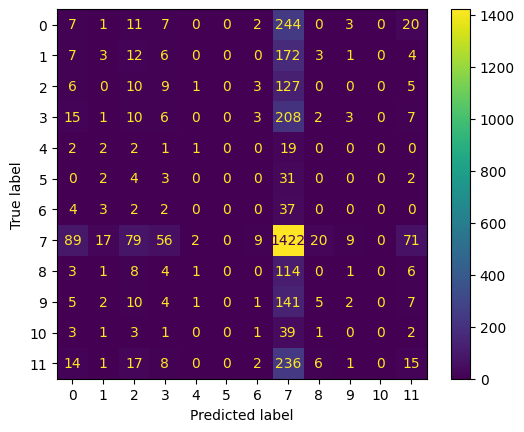

In [21]:
# Salvando o modelo treinado
model.save('modelo_transfer_learning_vgg_solar.h5')

# Calculando Matriz de Confusão
y_pred = model.predict(holdout_generator)
y_true = holdout_generator.classes

cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
wandb.log({"Matriz de Confusão": wandb.sklearn.plot_confusion_matrix(y_true, np.argmax(y_pred, axis=1))})

# Salvando o modelo treinado novamente
model.save('modelo_transfer_learning_vgg_solar.h5')

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()